<a href="https://colab.research.google.com/github/18520381/434_Project_10/blob/main/VGG16%20Project/Copy_of_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get data

In [1]:
from google.colab import drive
from torchvision import models
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/data

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/data


In [2]:
import warnings
warnings.filterwarnings('ignore')

import cv2       
import os

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.layers import Dense
from keras.layers import Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical    
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.callbacks import ReduceLROnPlateau

import random as rn
from tqdm import tqdm

Import data

In [ ]:
CLASS_NAME = ["apple", "orange"]
DATA_PATH = "../data/train/"
img_size = 112

images = []
labels = []
pbar = tqdm(total=2000)
for class_name in CLASS_NAME:
    for _, _, files in os.walk(DATA_PATH+class_name, topdown=False):
        for name in files:
            image = cv2.imread(DATA_PATH+""+class_name+"/"+name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_size,img_size))

            images.append(np.array(image))
            labels.append(str(class_name))

            pbar.update(1)
pbar.close()

100%|██████████| 2000/2000 [00:17<00:00, 115.20it/s]


In [ ]:
data = np.array(images)
labels = np.array(labels)

le = LabelEncoder()
y = le.fit_transform(labels)
y = to_categorical(y, 2)
X = data / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

np.random.seed(50)
rn.seed(50)

Setup a VGG16 

In [ ]:
size = img_size
fil = 8

model = Sequential()
model.add(Conv2D(input_shape=(size,size,3),filters=fil,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=fil,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=fil*2, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*2, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*4, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=fil*8, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*8, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*8, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=fil*8, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*8, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=fil*8, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(GlobalMaxPooling2D())
model.add(Dense(fil*4,activation='relu'))
model.add(Dense(2,activation="softmax"))

In [ ]:
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)

In [ ]:
datagen = ImageDataGenerator(featurewise_center= False,
                              samplewise_center= False,
                              featurewise_std_normalization= False,
                              samplewise_std_normalization=False,
                              rotation_range= 0,        
                              zca_whitening=False,
                              zoom_range=0.1,           
                              width_shift_range=0.1,   
                              height_shift_range=0.1,    
                              horizontal_flip=True,     
                              vertical_flip=False)       
                             
datagen.fit(X_train)

Compile and train the model

In [ ]:
model.save("/content/drive/MyDrive/ColabNotebooks/data/model6.h5")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 112, 112, 8)       224       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 8)       584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 16)        1168      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
import tensorflow as tf
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/ColabNotebooks/data/model7.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
model.compile(optimizer=Adam(lr = 1e-4), loss= 'categorical_crossentropy', metrics=['accuracy'])

batch_size=32
History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 5, validation_data = (X_test,y_test),                            
                              verbose = 1, steps_per_epoch= 25, callbacks=[model_checkpoint_callback])

Epoch 1/5
25/25 [==============================] - 26s 967ms/step - loss: 0.3888 - accuracy: 0.8319 - val_loss: 0.4172 - val_accuracy: 0.8125
Epoch 2/5
25/25 [==============================] - 23s 929ms/step - loss: 0.3880 - accuracy: 0.8402 - val_loss: 0.4171 - val_accuracy: 0.8125
Epoch 3/5
25/25 [==============================] - 23s 934ms/step - loss: 0.3703 - accuracy: 0.8513 - val_loss: 0.4099 - val_accuracy: 0.8200
Epoch 4/5
25/25 [==============================] - 23s 937ms/step - loss: 0.3719 - accuracy: 0.8450 - val_loss: 0.4134 - val_accuracy: 0.8150
Epoch 5/5
25/25 [==============================] - 23s 936ms/step - loss: 0.3930 - accuracy: 0.8352 - val_loss: 0.4134 - val_accuracy: 0.8125


Show accuracy and loss

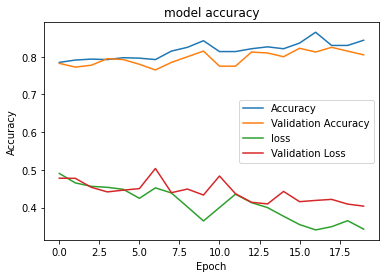

In [ ]:
import matplotlib.pyplot as plt
plt.plot(History.history["accuracy"])
plt.plot(History.history['val_accuracy'])
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

Save model


In [ ]:
model.save("/content/drive/MyDrive/ColabNotebooks/data/model7.h5")

Testing

apple


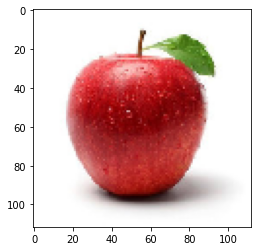

In [ ]:
import numpy as np
from keras.preprocessing import image
from tensorflow import keras

img_size = 112

path = '/content/drive/MyDrive/ColabNotebooks/data/test/apple/apple_2.jpg'

from keras.preprocessing import image
img = image.load_img(path, target_size = (img_size, img_size))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

saved_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5')
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("apple")
else:
    print("orange")

Make a layer1.v script 

In [ ]:
from tensorflow import keras
import cv2
import sys
import numpy
import re
import struct
numpy.set_printoptions(threshold=sys.maxsize)


base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/modelcnn.h5') 

kernel1 = base_model.layers[0].get_weights()[0]
bias1   = base_model.layers[0].get_weights()[1]

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

kernel = 3
conv2d = 3
layer = 8

f = open('/content/drive/MyDrive/ColabNotebooks/data/Layer1_banhmi', 'w')

f.write("module layer1_1#(\n")
f.write("    parameter DATA_WIDTH = 32,\n")
f.write("    parameter WIDTH = 112\n")
f.write(")(\n")
f.write("  input  [DATA_WIDTH*3-1:0] i_data,\n")
f.write("  input              clk, rst, empty, full_fifo_out,\n")
f.write("  output [DATA_WIDTH*" + str(layer) + "-1:0] o_data,\n")
f.write("  output             valid_out, rd_req_FIFO_IN    \n")       
f.write(");\n")
f.write("  wire [DATA_WIDTH-1:0] o_CORE_IP1 [" + str(layer-1) + ":0];\n")
f.write("  wire [DATA_WIDTH-1:0] o_CORE_IP2 [" + str(layer-1) + ":0];\n")
f.write("  wire [DATA_WIDTH-1:0] o_CORE_IP3 [" + str(layer-1) + ":0];\n")
f.write("  wire En, valid_in_line, valid_in_pipeline2D, valid_in_bias; \n")
f.write("  wire [3:0] valid_pipeline2D;\n")
f.write("  wire [1:0] valid_pipeline_bias;\n")
f.write("\n")
for i in range(0, layer):
  f.write("/// CON3d_" + str(i+1) + "///////////////////\n")
  for j in range(0, conv2d):
    f.write("  Con2D #(\n")
    f.write("      .DATA_WIDTH(DATA_WIDTH),\n")
    f.write("      .WIDTH(WIDTH+2),\n")
    for k in range(0, kernel):
      for l in range(0, kernel):
        f.write("      .k" + str(k*3+l+1) + "(32'b" + binary(kernel1[k][l][j][i]) + ")")
        if (k*3+l) != 8:
          f.write(",\n")
        else:
          f.write("\n")
    f.write("  ) CON2D_" + str(i*3+j+1) + "(\n")
    if j == 0:
      f.write("      .i_data(i_data[31:0]),\n")
    elif j == 1:
      f.write("      .i_data(i_data[63:32]),\n")
    else:
      f.write("      .i_data(i_data[95:64]),\n")
    f.write("      .clk(clk), \n")
    f.write("      .rst(rst), \n")
    f.write("      .En(En),\n")
    f.write("      .valid_in_line(valid_in_line),\n")
    f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
    f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
    f.write("      .o_data(o_CORE_IP" + str(j+1) + "[" + str(i) + "])\n")
    f.write("  );\n")
    f.write("\n")  
  f.write("\n")  
  f.write("pipeline_bias#(\n")
  f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
  f.write("    .bias(32'b" + binary(bias1[i]) + ")\n")
  f.write(")   op" + str(i) + "(\n")
  f.write("    .o_CORE_IP1(o_CORE_IP1[" + str(i) + "]), \n")
  f.write("    .o_CORE_IP2(o_CORE_IP2[" + str(i) + "]), \n") 
  f.write("    .o_CORE_IP3(o_CORE_IP3[" + str(i) + "]), \n")
  f.write("    .clk(clk),\n") 
  f.write("    .rst(rst),\n")
  f.write("    .valid_in_bias(valid_in_bias),\n")
  f.write("    .valid_pipeline(valid_pipeline_bias),\n")
  f.write("    .o_data(o_data[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
  f.write(");\n")
  f.write("\n")
f.write("  control_layer1#(\n")
f.write("      .WIDTH(WIDTH+2)\n")
f.write("    )control( \n")
f.write("      .clk(clk), \n")
f.write("      .rst(rst),\n")
f.write("      .empty(empty),\n")
f.write("      .full_fifo_out(full_fifo_out),\n")
f.write("      .valid_in_line(valid_in_line), \n")
f.write("      .En(En), \n")
f.write("      .rd_req_FIFO_IN(rd_req_FIFO_IN),\n")
f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
f.write("      .valid_in_bias(valid_in_bias),\n")
f.write("      .valid_pipeline_bias(valid_pipeline_bias),\n")
f.write("      .valid_out(valid_out)\n")
f.write("    );\n")
f.write("endmodule\n")
f.close()

Make a layer2.v script 

In [ ]:
from tensorflow import keras
import cv2
import sys
import numpy
import re
import struct
numpy.set_printoptions(threshold=sys.maxsize)


base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5') 

kernel1 = base_model.layers[1].get_weights()[0]
bias1   = base_model.layers[1].get_weights()[1]

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

kernel = 3
conv2d = 8
layer = 8

f = open('/content/drive/MyDrive/ColabNotebooks/data/Layer2.v', 'w')

f.write("module layer2_1#(\n")
f.write("    parameter DATA_WIDTH = 32,\n")
f.write("    parameter WIDTH = 112\n")
f.write(")(\n")
f.write("  input  [DATA_WIDTH*" + str(layer) + "-1:0] i_data,\n")
f.write("  input              clk, rst, empty, full_fifo_out,\n")
f.write("  output [DATA_WIDTH*" + str(layer) + "-1:0] o_data,\n")
f.write("  output             valid_out, rd_req_FIFO_IN    \n")       
f.write(");\n")
f.write("  wire [DATA_WIDTH*" + str(layer) + "-1:0] i_CORE_IP1 [" + str(layer-1) + ":0];\n")
f.write("  wire [DATA_WIDTH*" + str(layer) + "-1:0] i_CORE_IP2;\n")
f.write("  wire En, valid_in_line, valid_in_pipeline2D, valid_in_bias, valid_in_maxpooling, valid_in_max, valid_in_max1; \n")
f.write("  wire [3:0] valid_pipeline2D;\n")
f.write("  wire [3:0] valid_pipeline_bias;\n")
f.write("\n")
for i in range(0, layer):
  f.write("/// CON2D_" + str(i+1) + "///////////////////\n")
  for j in range(0, conv2d):
    f.write("  Con2D #(\n")
    f.write("      .DATA_WIDTH(DATA_WIDTH),\n")
    f.write("      .WIDTH(WIDTH+2),\n")
    for k in range(0, kernel):
      for l in range(0, kernel):
        f.write("      .k" + str(k*3+l+1) + "(32'b" + binary(kernel1[k][l][j][i]) + ")")
        if (k*3+l) != 8:
          f.write(",\n")
        else:
          f.write("\n")
    f.write("  ) CON2D_" + str(i*conv2d+j+1) + "(\n")
    f.write("      .i_data(i_data[DATA_WIDTH*" + str(j+1) + "-1:DATA_WIDTH*" + str(j) + "]),\n")
    f.write("      .clk(clk), \n")
    f.write("      .rst(rst), \n")
    f.write("      .En(En),\n")
    f.write("      .valid_in_line(valid_in_line),\n")
    f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
    f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
    f.write("      .o_data(i_CORE_IP1[" + str(i) + "][DATA_WIDTH*" + str(j+1) + "-1:DATA_WIDTH*" + str(j) + "])\n")
    f.write("  );\n")
    f.write("\n") 

  f.write("\n")  
  f.write("pipeline_layer2#(\n")
  f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
  f.write("    .bias(32'b" + binary(bias1[i]) + ")\n")
  f.write(")   op" + str(i+1) + "(\n")
  f.write("    .i_pipeline_layer2(i_CORE_IP1[" + str(i) + "]), \n")
  f.write("    .clk(clk),\n") 
  f.write("    .rst(rst),\n")
  f.write("    .valid_in_bias(valid_in_bias),\n")
  f.write("    .valid_pipeline(valid_pipeline_bias),\n")
  f.write("    .o_data(i_CORE_IP2[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
  f.write(");\n")
  f.write("\n")

  f.write("  MaxPooling #(\n")
  f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
  f.write("    .WIDTH(WIDTH)\n")
  f.write("  ) maxpooling" + str(i+1) + "(\n")
  f.write("    .i_data(i_CORE_IP2[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "]),\n")
  f.write("    .valid_in(valid_in_maxpooling), \n")
  f.write("    .valid_in_max(valid_in_max), \n")
  f.write("    .valid_in_max1(valid_in_max1), \n")
  f.write("    .clk(clk), \n")
  f.write("    .rst(rst),\n")
  f.write("    .o_data(o_data[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
  f.write("  );\n")
  f.write("\n")

f.write("  control_layer2#(\n")
f.write("      .WIDTH(WIDTH)\n")
f.write("    )control( \n")
f.write("      .clk(clk), \n")
f.write("      .rst(rst),\n")
f.write("      .empty(empty),\n")
f.write("      .full_fifo_out(full_fifo_out),\n")
f.write("      .valid_in_line(valid_in_line), \n")
f.write("      .En(En), \n")
f.write("      .rd_req_FIFO_IN(rd_req_FIFO_IN),\n")
f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
f.write("      .valid_in_bias(valid_in_bias),\n")
f.write("      .valid_pipeline_bias(valid_pipeline_bias),\n")
f.write("      .valid_in_maxpooling(valid_in_maxpooling), \n")
f.write("      .valid_in_max(valid_in_max), \n")
f.write("      .valid_in_max1(valid_in_max1),\n")
f.write("      .valid_out(valid_out)\n")
f.write("    );\n")
f.write("endmodule\n")
f.close()

Make a Layer3 script

In [ ]:
base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5') 

kernel1 = base_model.layers[3].get_weights()[0]
bias1   = base_model.layers[3].get_weights()[1]

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

kernel = 3
conv2d = 8
layer = 16

f = open('/content/drive/MyDrive/ColabNotebooks/data/Layer3.txt', 'w')

f.write("module layer3_1#(\n")
f.write("    parameter DATA_WIDTH = 32,\n")
f.write("    parameter WIDTH = 56\n")
f.write(")(\n")
f.write("  input  [DATA_WIDTH*" + str(conv2d) + "-1:0] i_data,\n")
f.write("  input              clk, rst, empty, full_fifo_out,\n")
f.write("  output [DATA_WIDTH*" + str(layer) + "-1:0] o_data,\n")
f.write("  output             valid_out, rd_req_FIFO_IN    \n")       
f.write(");\n")
f.write("  wire [DATA_WIDTH*" + str(conv2d) + "-1:0] i_CORE_IP1 [" + str(layer-1) + ":0];\n")
f.write("  wire En, valid_in_line, valid_in_pipeline2D, valid_in_bias; \n")
f.write("  wire [3:0] valid_pipeline2D;\n")
f.write("  wire [3:0] valid_pipeline_bias;\n")
f.write("\n")
for i in range(0, layer):
  f.write("/// CON2D_" + str(i+1) + "///////////////////\n")
  for j in range(0, conv2d):
    f.write("  Con2D #(\n")
    f.write("      .DATA_WIDTH(DATA_WIDTH),\n")
    f.write("      .WIDTH(WIDTH+2),\n")
    for k in range(0, kernel):
      for l in range(0, kernel):
        f.write("      .k" + str(k*3+l+1) + "(32'b" + binary(kernel1[k][l][j][i]) + ")")
        if (k*3+l) != 8:
          f.write(",\n")
        else:
          f.write("\n")
    f.write("  ) CON2D_" + str(i*conv2d+j+1) + "(\n")
    f.write("      .i_data(i_data[DATA_WIDTH*" + str(j+1) + "-1:DATA_WIDTH*" + str(j) + "]),\n")
    f.write("      .clk(clk), \n")
    f.write("      .rst(rst), \n")
    f.write("      .En(En),\n")
    f.write("      .valid_in_line(valid_in_line),\n")
    f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
    f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
    f.write("      .o_data(i_CORE_IP1[" + str(i) + "][DATA_WIDTH*" + str(j+1) + "-1:DATA_WIDTH*" + str(j) + "])\n")
    f.write("  );\n")
    f.write("\n") 

  f.write("\n")  
  f.write("pipeline_layer2#(\n")
  f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
  f.write("    .bias(32'b" + str(binary(bias1[i])) + ")\n")
  f.write(")   op" + str(i+1) + "(\n")
  f.write("    .i_pipeline_layer2(i_CORE_IP1[" + str(i) + "]), \n")
  f.write("    .clk(clk),\n") 
  f.write("    .rst(rst),\n")
  f.write("    .valid_in_bias(valid_in_bias),\n")
  f.write("    .valid_pipeline(valid_pipeline_bias),\n")
  f.write("    .o_data(o_data[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
  f.write(");\n")
  f.write("\n")

f.write("  control_layer3#(\n")
f.write("      .WIDTH(WIDTH)\n")
f.write("    )control( \n")
f.write("      .clk(clk), \n")
f.write("      .rst(rst),\n")
f.write("      .empty(empty),\n")
f.write("      .full_fifo_out(full_fifo_out),\n")
f.write("      .valid_in_line(valid_in_line), \n")
f.write("      .En(En), \n")
f.write("      .rd_req_FIFO_IN(rd_req_FIFO_IN),\n")
f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
f.write("      .valid_in_bias(valid_in_bias),\n")
f.write("      .valid_pipeline_bias(valid_pipeline_bias),\n")
f.write("      .valid_out(valid_out)\n")
f.write("    );\n")
f.write("endmodule\n")
f.close()

Make a Layer4 script

In [7]:
from tensorflow import keras
import cv2
import sys
import numpy
import re
import struct
numpy.set_printoptions(threshold=sys.maxsize)


base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5') 

kernel1 = base_model.layers[4].get_weights()[0]
bias1   = base_model.layers[4].get_weights()[1]

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

kernel = 3
conv2d = 16
layer = 16

f = open('/content/drive/MyDrive/ColabNotebooks/data/Layer4.txt', 'w')

f.write("module layer4_1#(\n")
f.write("    parameter DATA_WIDTH = 32,\n")
f.write("    parameter WIDTH = 56\n")
f.write(")(\n")
f.write("  input  [DATA_WIDTH*" + str(layer) + "-1:0] i_data,\n")
f.write("  input              clk, rst, empty, full_fifo_out,\n")
f.write("  output [DATA_WIDTH*" + str(layer) + "-1:0] o_data,\n")
f.write("  output             valid_out, rd_req_FIFO_IN    \n")       
f.write(");\n")
f.write("  wire [DATA_WIDTH*" + str(layer) + "-1:0] i_CORE_IP1 [" + str(layer-1) + ":0];\n")
f.write("  wire [DATA_WIDTH*" + str(layer) + "-1:0] i_CORE_IP2;\n")
f.write("  wire En, valid_in_line, valid_in_pipeline2D, valid_in_bias, valid_in_maxpooling, valid_in_max, valid_in_max1; \n")
f.write("  wire [3:0] valid_pipeline2D;\n")
f.write("  wire [4:0] valid_pipeline_bias;\n")
f.write("\n")
for i in range(0, layer):
  f.write("/// CON2D_" + str(i+1) + "///////////////////\n")
  for j in range(0, conv2d):
    f.write("  Con2D #(\n")
    f.write("      .DATA_WIDTH(DATA_WIDTH),\n")
    f.write("      .WIDTH(WIDTH+2),\n")
    for k in range(0, kernel):
      for l in range(0, kernel):
        f.write("      .k" + str(k*3+l+1) + "(32'b" + binary(kernel1[k][l][j][i]) + ")")
        if (k*3+l) != 8:
          f.write(",\n")
        else:
          f.write("\n")
    f.write("  ) CON2D_" + str(i*conv2d+j+1) + "(\n")
    f.write("      .i_data(i_data[DATA_WIDTH*" + str(j+1) + "-1:DATA_WIDTH*" + str(j) + "]),\n")
    f.write("      .clk(clk), \n")
    f.write("      .rst(rst), \n")
    f.write("      .En(En),\n")
    f.write("      .valid_in_line(valid_in_line),\n")
    f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
    f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
    f.write("      .o_data(i_CORE_IP1[" + str(i) + "][DATA_WIDTH*" + str(j+1) + "-1:DATA_WIDTH*" + str(j) + "])\n")
    f.write("  );\n")
    f.write("\n") 

  f.write("\n")  
  f.write("pipeline_layer4#(\n")
  f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
  f.write("    .bias(32'b" + binary(bias1[i]) + ")\n")
  f.write(")   op" + str(i+1) + "(\n")
  f.write("    .i_pipeline_layer4(i_CORE_IP1[" + str(i) + "]), \n")
  f.write("    .clk(clk),\n") 
  f.write("    .rst(rst),\n")
  f.write("    .valid_in_bias(valid_in_bias),\n")
  f.write("    .valid_pipeline(valid_pipeline_bias),\n")
  f.write("    .o_data(i_CORE_IP2[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
  f.write(");\n")
  f.write("\n")

  f.write("  MaxPooling #(\n")
  f.write("    .DATA_WIDTH(DATA_WIDTH),\n")
  f.write("    .WIDTH(WIDTH)\n")
  f.write("  ) maxpooling" + str(i+1) + "(\n")
  f.write("    .i_data(i_CORE_IP2[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "]),\n")
  f.write("    .valid_in(valid_in_maxpooling), \n")
  f.write("    .valid_in_max(valid_in_max), \n")
  f.write("    .valid_in_max1(valid_in_max1), \n")
  f.write("    .clk(clk), \n")
  f.write("    .rst(rst),\n")
  f.write("    .o_data(o_data[DATA_WIDTH*" + str(i+1) + "-1:DATA_WIDTH*" + str(i) + "])\n")
  f.write("  );\n")
  f.write("\n")

f.write("  control_layer4#(\n")
f.write("      .WIDTH(WIDTH)\n")
f.write("    )control( \n")
f.write("      .clk(clk), \n")
f.write("      .rst(rst),\n")
f.write("      .empty(empty),\n")
f.write("      .full_fifo_out(full_fifo_out),\n")
f.write("      .valid_in_line(valid_in_line), \n")
f.write("      .En(En), \n")
f.write("      .rd_req_FIFO_IN(rd_req_FIFO_IN),\n")
f.write("      .valid_in_pipeline2D(valid_in_pipeline2D),\n")
f.write("      .valid_pipeline2D(valid_pipeline2D),\n")
f.write("      .valid_in_bias(valid_in_bias),\n")
f.write("      .valid_pipeline_bias(valid_pipeline_bias),\n")
f.write("      .valid_in_maxpooling(valid_in_maxpooling), \n")
f.write("      .valid_in_max(valid_in_max), \n")
f.write("      .valid_in_max1(valid_in_max1),\n")
f.write("      .valid_out(valid_out)\n")
f.write("    );\n")
f.write("endmodule\n")
f.close()

Get layer in VGG16 by Python

In [14]:
import matplotlib.pyplot as plt
from keras import backend as K

def feature_map_show(x, title):
    num_out_channels = x.shape[2]
    num_diagram_col = 4
    if num_out_channels >= 16:
        num_diagram_col = 8
    num_diagram_row = np.ceil(num_out_channels / num_diagram_col)

    num_diagram_col = int(num_diagram_col)
    num_diagram_row = int(num_diagram_row)

    fig, axs = plt.subplots(
        nrows=num_diagram_row,
        ncols=num_diagram_col,
        figsize=(7 * num_diagram_col, 5 * num_diagram_row)
    )

    for i in range(num_out_channels):
        row = i // num_diagram_col
        col = i  % num_diagram_col

        axs[row][col].imshow(x[:, :, i], cmap='gray')
        axs[row][col].axis('off')

    fig.suptitle(title, fontsize=30)
    fig.savefig('{:s}.png'.format(title))

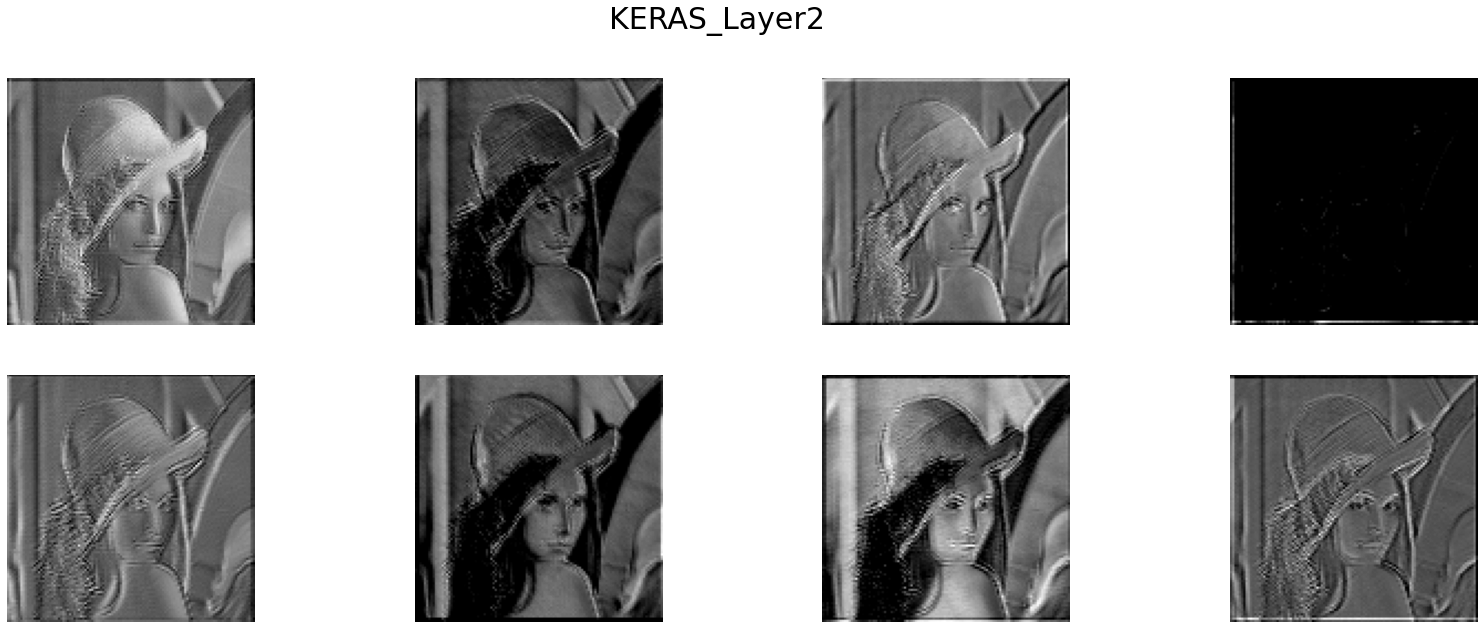

In [ ]:
from tensorflow import keras
import cv2

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5')

path = '/content/drive/MyDrive/ColabNotebooks/data/Lenna.png'
x = cv2.imread(path)
x = cv2.resize(x,(112,112))
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x / 255.0
x.shape

conv1 = base_model.layers[0]
conv2 = base_model.layers[1]
y = conv1(x[np.newaxis,:,:,:])
z = conv2(y)

y = y.numpy()
y = y.squeeze()

z = z.numpy()
z = z.squeeze()

feature_map_show(y, "KERAS_Layer1")

Convert picture to binary

In [18]:
import cv2
import struct

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

imagein = cv2.imread('/content/drive/MyDrive/ColabNotebooks/data/banhmi.png')
size = (112, 112)
image = cv2.resize(imagein, size, interpolation= cv2.INTER_AREA)

f = open('/content/drive/MyDrive/ColabNotebooks/data/banhmi.txt', 'w')

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        b, g, r = image[i,j]
        x = binary(b/255.0) + binary(g/255.0) + binary(r/255.0) + '\n'
        f.write(x)       
f.close()

Compare

Mean square error: 3.76737488767457e-16


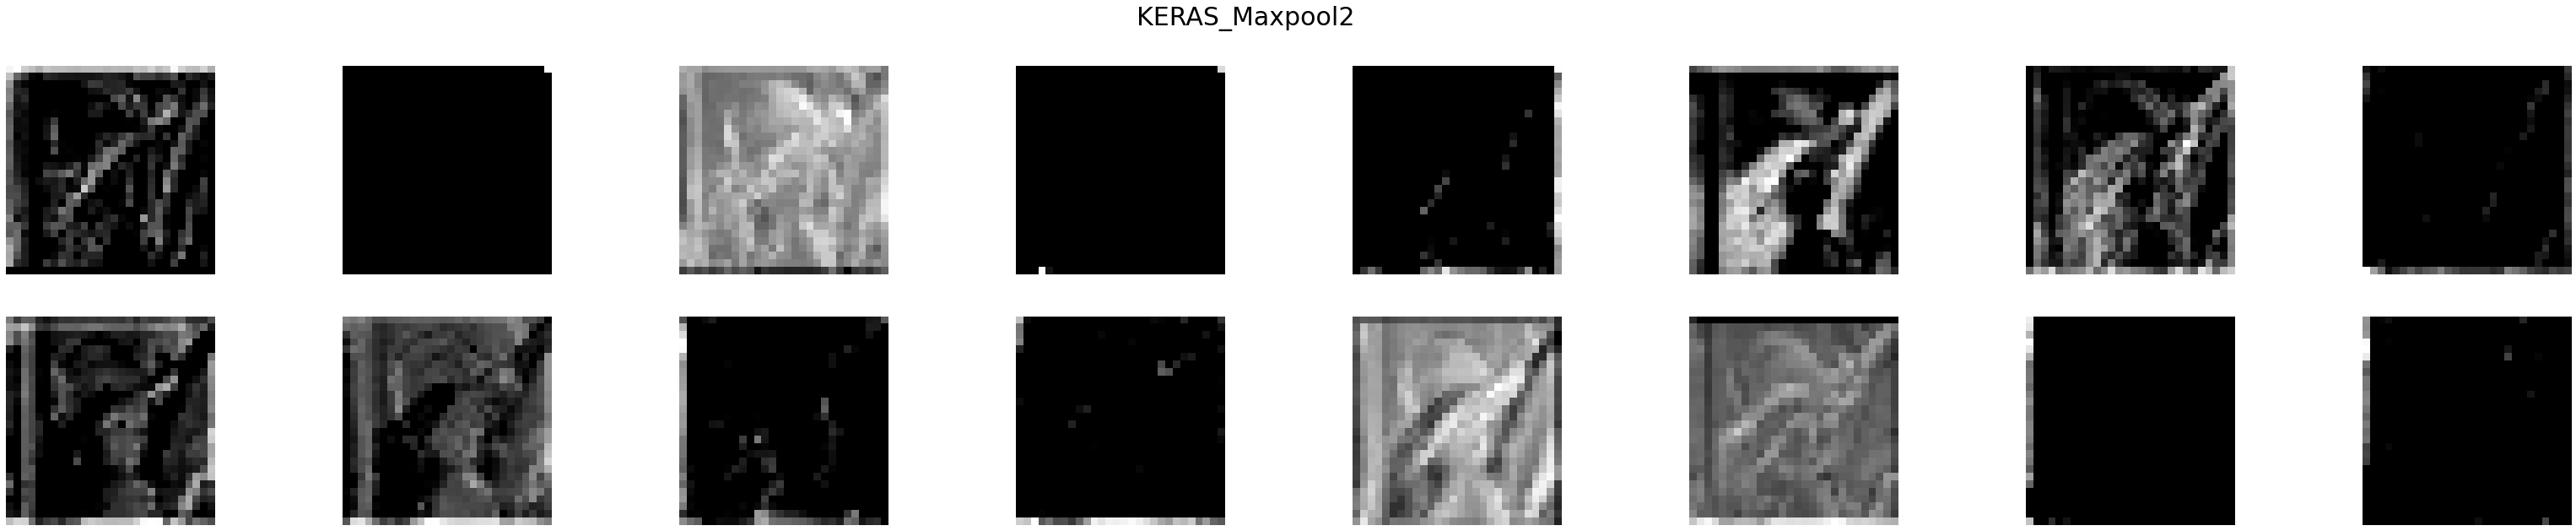

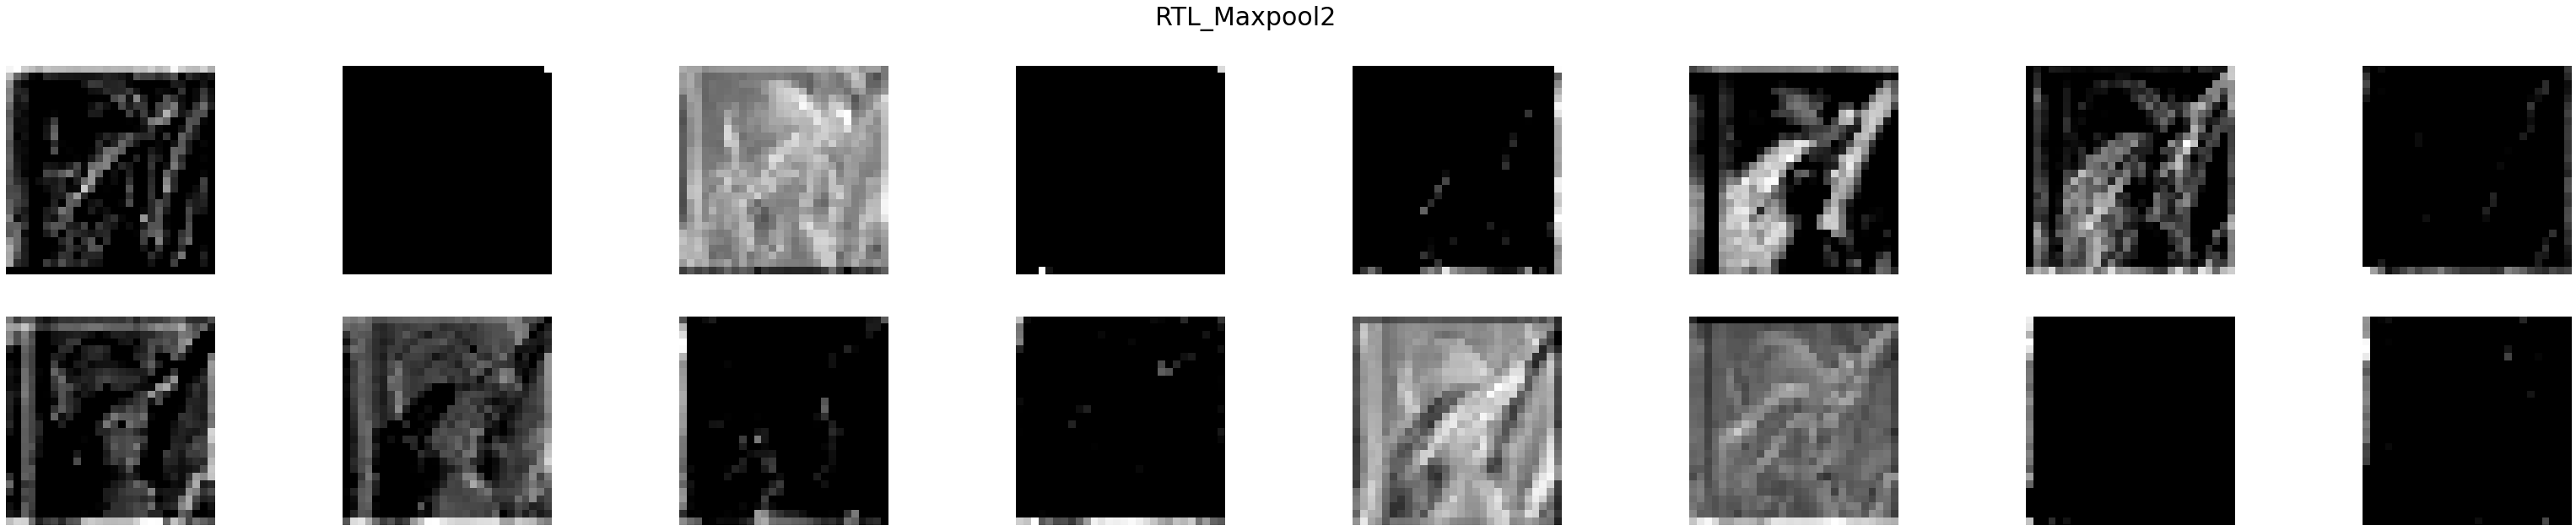

In [16]:
import struct
from PIL import Image


from tensorflow import keras
import cv2

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5')

path = '/content/drive/MyDrive/ColabNotebooks/data/Lenna.png'
x = cv2.imread(path)
x = cv2.resize(x,(112,112), interpolation= cv2.INTER_AREA)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x /255.0
x.shape

conv1 = base_model.layers[0]
conv2 = base_model.layers[1]
maxpool1 = base_model.layers[2]
conv3 = base_model.layers[3]
conv4 = base_model.layers[4]
maxpool2 = base_model.layers[5]

lay1 = conv1(x[np.newaxis,:,:,:])
lay2 = conv2(lay1)
pool1 = maxpool1(lay2)
lay3 = conv3(pool1)
lay4 = conv4(lay3)
pool2 = maxpool2(lay4)

lay1 = lay1.numpy()
lay1 = lay1.squeeze()

lay2 = lay2.numpy()
lay2 = lay2.squeeze()

pool1 = pool1.numpy()
pool1 = pool1.squeeze()

lay3 = lay3.numpy()
lay3 = lay3.squeeze()

pool2 = pool2.numpy()
pool2 = pool2.squeeze()

feature_map_show(pool2, "KERAS_Maxpool2")

layer = 8
img_size = 28
size = (img_size, img_size)

def bintofloat(value):
    temp = int(value, 2)
    return struct.unpack('f', struct.pack('I', temp))[0]

accu = 0

for k in range(0, layer):
  f = open('/content/drive/MyDrive/ColabNotebooks/data/Lenna_convert' + str(k) + '.txt', 'r')
  t = f.readline()
  t = f.readline()
  t = f.readline()
  for i in range(size[0]):
    for j in range(size[1]):
        t = f.readline()
        x = float(bintofloat(t))
        accu += (x - pool2[i][j][k])*(x - pool2[i][j][k])
        pool2[i][j][k] = x
  f.close()

print("Mean square error:",accu/(img_size*img_size*layer))

feature_map_show(pool2, "RTL_Maxpool2")

Print 1 layer with PIL

0


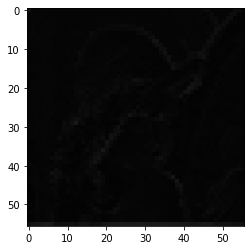

In [ ]:
import struct
from PIL import Image

def bintofloat(value):
    temp = int(value, 2)
    return struct.unpack('f', struct.pack('I', temp))[0]

accu2 = 0

layer = 8

img_size = 56
size = (img_size, img_size)

for k in range(0, 1):
  print(k)
  accu = 0
  f = open('/content/drive/MyDrive/ColabNotebooks/data/Lenna_convert' + str(k) + '.txt', 'r')
  new_img = Image.new('RGB', size)
  pixels_new = new_img.load()
  t = f.readline()
  t = f.readline()
  t = f.readline()
  for i in range(new_img.size[0]):
    for j in range(new_img.size[1]):
        t = f.readline()
        x = float(bintofloat(t))
        pixels_new[j,i] = int(x*255), int(x*255), int(x*255)
        # accu += (x - y[i][j][k]/255.0)*(x - y[i][j][k]/255.0)
        
  f.close()
  # print("pic ", k,":",accu/(112*112))
  # accu2 += accu
  plt.imshow(new_img)
  plt.show()
  new_img.show()

# print("total :", accu2/(112*112*8))

Python code testing

In [ ]:
import math
import struct
from PIL import Image
img_size = 112
size = (img_size, img_size)

from tensorflow import keras
import cv2

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5')

path = '/content/drive/MyDrive/ColabNotebooks/data/Lenna.png'
x = cv2.imread(path)
x = cv2.resize(x,(112,112), interpolation= cv2.INTER_AREA)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x / 255.0

conv1 = base_model.layers[0]
conv2 = base_model.layers[1]
maxpool1 = base_model.layers[2]

lay1 = conv1(x[np.newaxis,:,:,:])
lay2 = conv2(lay1)
lay3 = maxpool1(lay2)

lay1 = lay1.numpy()
lay1 = lay1.squeeze()

lay2 = lay2.numpy()
lay2 = lay2.squeeze()

lay3 = lay3.numpy()
lay3 = lay3.squeeze()

# feature_map_show(lay2, "KERAS_Layer2")
kernel1 = base_model.layers[0].get_weights()[0]
bias1   = base_model.layers[0].get_weights()[1]
kernel2 = base_model.layers[1].get_weights()[0]
bias2   = base_model.layers[1].get_weights()[1]


kernel = 3
conv2d = 8
layer = 8
size = 112

for i in range (0, 1):
  for u in range (0, size):
    for v in range (0, size):
      t1 = 0
      for j in range (0, conv2d):
        t0 = 0
        if (u==0) and (v==0):
          print("conv2d_",j,"////////////////")
        for k in range (-1, kernel-1):
          for l in range (-1, kernel-1):
            if ((u+k >= 0) and (v+l >=0) and (u+k < size) and (v+l < size)):           
              t0 += lay1[u+k][v+l][j]*kernel2[k+1][l+1][j][i]
            if (u==0) and (v==0):
              print(u+k," ",v+l," ",lay1[u+k][v+l][j]," ",kernel2[k+1][l+1][j][i]," ",lay1[u+k][v+l][j]*kernel2[k+1][l+1][j][i])
        t1 += t0
        if (u==0) and (v==0):
          print("tong conv:",t0)
      t1 += bias2[i]
      if (u==0) and (v==0):
          print("bias:",bias2[i],"\n\n",t1)

      # accu += abs(lay2[u][v][i]/255.0 - t1)
      if (t1>=0):
        lay2[u][v][i] = t1
      else:
        lay2[u][v][i] = 0
  # print("pic ",i," : ",1-accu/(size*size))    


# feature_map_show(lay2, "PYTHON_layer2")

conv2d_ 0 ////////////////
-1   -1   0.0   0.058895085   0.0
-1   0   0.0   0.055587534   0.0
-1   1   0.0   -0.12519541   -0.0
0   -1   0.0   0.07630178   0.0
0   0   0.0   0.13508838   0.0
0   1   0.0   0.18841659   0.0
1   -1   0.0   0.02288774   0.0
1   0   0.0   -0.16806641   -0.0
1   1   0.0   0.05901733   0.0
tong conv: 0.0
conv2d_ 1 ////////////////
-1   -1   0.0   -0.10399941   -0.0
-1   0   0.0   -0.100703016   -0.0
-1   1   0.0   -0.025735727   -0.0
0   -1   0.0   0.18822138   0.0
0   0   0.0   0.11446596   0.0
0   1   0.0   0.18599465   0.0
1   -1   0.0   0.046768826   0.0
1   0   0.0   0.20215724   0.0
1   1   0.0   -0.03467272   -0.0
tong conv: 0.0
conv2d_ 2 ////////////////
-1   -1   0.08702372   -0.029336756   -0.0025529936
-1   0   0.08937287   -0.049284082   -0.00440466
-1   1   0.18730682   -0.019301822   -0.003615363
0   -1   0.08154002   0.19825178   0.016165454
0   0   0.0   -0.096748844   -0.0
0   1   0.03077044   0.11509271   0.0035414533
1   -1   0.0   -0.13980

Get kernel layer

In [ ]:
base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5') 

kernel1 = base_model.layers[0].get_weights()[0]
bias1   = base_model.layers[0].get_weights()[1]

kernel = 3
conv2d = 3
layer = 8

for k in range(0, layer):
  print("conv3d_",k+1)
  for l in range(0, conv2d):
    print("conv2d_",k*conv2d+l+1)
    for i in range (0, kernel):
      for j in range (0, kernel):
        print(kernel1[i][j][l][k])




gelayer2

In [ ]:
import math
import struct
from PIL import Image
img_size = 112
size = (img_size, img_size)

from tensorflow import keras
import cv2

base_model = keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/data/model6.h5')

path = '/content/drive/MyDrive/ColabNotebooks/data/Lenna.png'
x = cv2.imread(path)
x = cv2.resize(x,(112,112), interpolation= cv2.INTER_AREA)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x / 255.0

conv1 = base_model.layers[0]
conv2 = base_model.layers[1]
maxpool1 = base_model.layers[2]

lay1 = conv1(x[np.newaxis,:,:,:])
lay2 = conv2(lay1)
lay3 = maxpool1(lay2)

lay1 = lay1.numpy()
lay1 = lay1.squeeze()

lay2 = lay2.numpy()
lay2 = lay2.squeeze()

lay3 = lay3.numpy()
lay3 = lay3.squeeze()

# feature_map_show(lay2, "KERAS_Layer2")
kernel1 = base_model.layers[0].get_weights()[0]
bias1   = base_model.layers[0].get_weights()[1]
kernel2 = base_model.layers[1].get_weights()[0]
bias2   = base_model.layers[1].get_weights()[1]

def binary(num):
    return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))


f = open('/content/drive/MyDrive/ColabNotebooks/data/Lenna_conv2.txt', 'w')

for i in range(0, 10):
  x = ''
  for j in range(0, 8):
    x += binary(lay1[0][i][j])
  f.write(x+'\n')       
f.close()
